<a href="https://colab.research.google.com/github/aruaru0/pytorch-tests/blob/main/MNIST_CNN_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

In [2]:
train_dataset = torchvision.datasets.MNIST(root="data",
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)
valid_dataset = torchvision.datasets.MNIST(root="data",
                                           train=False,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

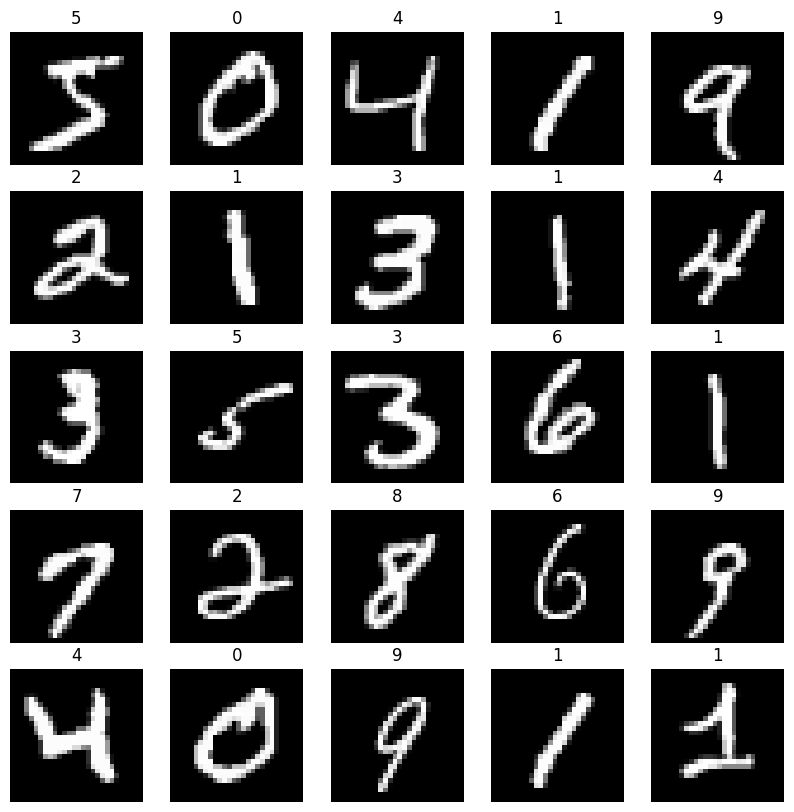

In [3]:
# データを確認
fig, ax = plt.subplots(5,5, figsize=(10,10))

for i in range(25) :
  img, label = train_dataset[i]
  r, c = i//5, i%5
  ax[r, c].imshow(img.squeeze(), cmap="gray")
  ax[r, c].axis("off")
  ax[r, c].set_title(label)

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# class MyModel(nn.Module):
#   def __init__(self, input_size):
#     super(MyModel, self).__init__()
#     self.size = input_size*input_size
#     self.fc1 = nn.Linear(self.size, 1024)
#     self.fc2 = nn.Linear(1024, 256)
#     self.fc3 = nn.Linear(256, 10)
#   def forward(self, x):
#     x = x.view(-1, self.size)
#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)
#     return x

In [6]:
# x, label = train_dataset[0]
# x.shape, label

In [7]:
# x, label = train_dataset[0]
# x = x.unsqueeze(0)
# conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
# conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
# pool = nn.MaxPool2d(2,2)
# act = nn.ReLU()
# pool2 = nn.AdaptiveAvgPool1d(1024)
# dropout2d = nn.Dropout2d(0.5)
# dropout1d = nn.Dropout1d(0.5)
# fc1 = nn.Linear(1024, 256)
# fc2 = nn.Linear(256, 10)

# x = pool(act(conv1(x)))
# x = pool(act(conv2(x)))
# x = dropout2d(x)
# x = torch.flatten(x, start_dim=1)
# x = pool2(x)
# x = act(fc1(x))
# x = dropout1d(x)
# x = fc2(x)
# x.shape


In [8]:
class MyCNNModel(nn.Module):
  def __init__(self, input_size):
    super(MyCNNModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.act = nn.ReLU()
    self.pool2 = nn.AdaptiveAvgPool1d(1024)
    self.fc1 = nn.Linear(1024, 256)
    self.fc2 = nn.Linear(256, 10)
  def forward(self, x):
    x = self.pool(self.act(self.conv1(x)))
    x = self.pool(self.act(self.conv2(x)))
    x = torch.flatten(x, start_dim=1)
    x = self.pool2(x)
    x = self.act(self.fc1(x))
    x = self.fc2(x)
    return x


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyCNNModel(28).to(device)
model

MyCNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act): ReLU()
  (pool2): AdaptiveAvgPool1d(output_size=1024)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
def do_train(model, device, loader, criterion, optimizer):
  model.train()
  tot_loss = 0.0
  tot_score = 0.0
  for images, labels in tqdm(loader, desc="train"):
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    tot_loss += loss.detach().item()
    tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())

  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

In [12]:
def do_valid(model, device, loader, criterion):
  model.eval()
  tot_loss = 0.0
  tot_score = 0.0
  with torch.no_grad():
    for images, labels in tqdm(loader, desc="valid"):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      tot_loss += loss.detach().item()
      tot_score += accuracy_score(labels.cpu(), outputs.argmax(dim=1).cpu())
  tot_loss /= len(loader)
  tot_score /= len(loader)
  return tot_loss, tot_score

In [13]:
num_epochs = 10
for epoch in range(num_epochs):
  print(f'[EPOCH {epoch+1}]')
  train_loss, train_acc = do_train(model, device, train_loader, criterion, optimizer)
  valid_loss, valid_acc = do_valid(model, device, valid_loader, criterion)
  print(f"--> train loss {train_loss}, train accuracy {train_acc}, valid loss {valid_loss} valid accuracy {valid_acc}")

[EPOCH 1]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.2491167893847709, train accuracy 0.9240405117270789, valid loss 0.0676688662649334 valid accuracy 0.9770103503184714
[EPOCH 2]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.06991415744029812, train accuracy 0.9783115671641791, valid loss 0.05422432527463634 valid accuracy 0.9828821656050956
[EPOCH 3]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.04854081714008776, train accuracy 0.9849413646055437, valid loss 0.03558798853631812 valid accuracy 0.9879578025477707
[EPOCH 4]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.038818072468942914, train accuracy 0.9880063965884861, valid loss 0.03254426605892416 valid accuracy 0.9887539808917197
[EPOCH 5]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.03033721427269864, train accuracy 0.9907549307036247, valid loss 0.03060023601338005 valid accuracy 0.9891520700636943
[EPOCH 6]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.025017391440822486, train accuracy 0.9919043176972282, valid loss 0.03409232943332502 valid accuracy 0.9876592356687898
[EPOCH 7]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.020570307692940056, train accuracy 0.9931203358208955, valid loss 0.03274258374274978 valid accuracy 0.9896496815286624
[EPOCH 8]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.016291813495491393, train accuracy 0.9944696162046909, valid loss 0.047512531508679096 valid accuracy 0.986265923566879
[EPOCH 9]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.014675220265672988, train accuracy 0.9950692963752665, valid loss 0.028091622677122684 valid accuracy 0.9909434713375797
[EPOCH 10]


train:   0%|          | 0/938 [00:00<?, ?it/s]

valid:   0%|          | 0/157 [00:00<?, ?it/s]

--> train loss 0.013030382923994666, train accuracy 0.9957689232409381, valid loss 0.027705744465230404 valid accuracy 0.9917396496815286


In [14]:
model.fc2 = nn.Identity()
model.eval()

features = None
classes  = None

for images, labels in tqdm(valid_loader):
  with torch.no_grad():
    images = images.to(device)
    outputs = model(images)
  # print(outputs.shape)
  if classes is None:
    classes = labels.cpu()
  else:
    classes = torch.cat((classes, labels.cpu()))

  if features is None:
    features = outputs.cpu()
  else:
    features = torch.cat((features, outputs.cpu()))

  0%|          | 0/157 [00:00<?, ?it/s]

In [15]:
!pip install umap-learn

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


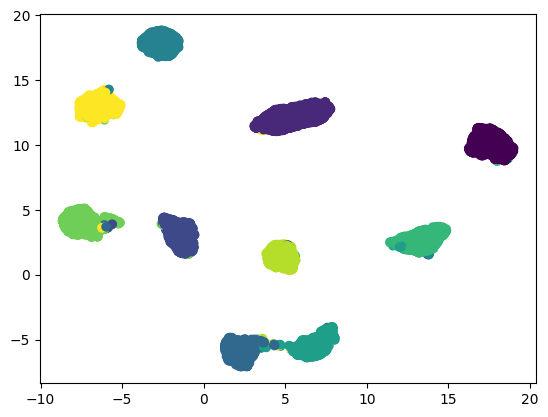

In [16]:
import umap
umap = umap.UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(features)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=classes)
plt.show()